#  I  made some modifications for this sample

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For Plotting
import matplotlib.pyplot as plt

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(3407)

# Args

In [2]:
class Args:
    def __init__(self) -> None:

        '''***********- model params -*************'''
        self.model_name = "hw1"

        '''***********- data path -*************'''
        self.data_path = '../../../data/hw1/'
        self.train_file='covid.train.csv'
        self.val_file = ''
        self.test_file = 'covid.test.csv'
        self.submit_file = '../../../submit/{}.csv'.format(self.model_name)

        '''***********- model path -*************'''
        self.MODEL_PATH = '../../../ckpts/{}'.format(self.model_name)
        if not os.path.exists(self.MODEL_PATH):
            os.makedirs(self.MODEL_PATH)

        '''***********- cpu or gpu and dara parallel -*************'''
        # self.gpus = [] # cpu
        # self.gpus = [0] # single gpu
        self.gpus = [0] # multi gpu
        self.WORKERS = 5 # num of workers for data loader

        '''***********- Hyper Arguments -*************'''
        self.rand_seed=40
        self.batch_size = 256
        self.lr = 1e-3
        self.epochs = 200
        self.split_ratio = 0.2
        self.patience = 20
        self.l2_lambda = 0.1

# Utils

In [3]:
def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

# Dataset

In [4]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Model

In [5]:
# baseline
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        x = self.net(x)
        x = x.squeeze(1)
        return x

# Feature selection

In [6]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        # 计算每个特征与y_train的相关系数
        correlations = np.array([np.corrcoef(raw_x_train[:, i], y_train)[0, 1] for i in range(raw_x_train.shape[1])])
        # 选择相关系数绝对值大于0.1的特征
        feat_idx = np.where(np.abs(correlations) > 0.1)[0]
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Trainer

In [7]:
def trainer():
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)
    # Print out the data size.
    print(f"""train_data size: {train_data.shape} 
          valid_data size: {valid_data.shape} 
          test_data size: {test_data.shape}""")

    print("Selecting features...")
    x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, select_all=False)
    # Print out the number of features.
    print(f'number of features: {x_train.shape[1]}')

    train_dataset, val_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                                COVID19Dataset(x_valid, y_valid), \
                                                COVID19Dataset(x_test)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    print("***********- ***********- Training begin -*************")
    train_epochs_loss = []
    # train_epochs_mse = []
    valid_epochs_loss = []
    # valid_epochs_mse = []
    val_inf = np.inf
    patience_counter = 0
    for epoch in range(args.epochs):
        model.train()
        train_epoch_loss = []
        # train_epoch_mse = []
        # =========================train=======================
        for idx, (X, y) in enumerate(tqdm(train_dataloader)):
            if (len(args.gpus) > 0):
                X, y = X.cuda(), y.cuda()

            # 计算 L2 正则化损失
            l2_reg = torch.tensor(0.).cuda()
            for param in model.parameters():
                l2_reg += torch.norm(param)
            
            outputs = model(X)
            optimizer.zero_grad()
            loss = criterion(outputs, y) + args.l2_lambda * l2_reg
            # mse = torch.nn.functional.mse_loss(outputs, y)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0) #用来梯度裁剪
            optimizer.step()
            train_epoch_loss.append(loss.item())
            # train_epoch_mse.append(mse.item())
        train_epochs_loss.append(np.average(train_epoch_loss))
        # train_epochs_mse.append(np.average(train_epoch_mse))
        # print("Train epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(train_epoch_loss), np.average(train_epoch_mse)))
        print("Train epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(train_epoch_loss)))
        # =========================val=========================
        with torch.no_grad():
            model.eval()
            val_epoch_loss = []
            # val_epoch_mse = []
            for idx, (X, y) in enumerate(tqdm(val_dataloader)):
                if (len(args.gpus) > 0):
                    X, y = X.cuda(), y.cuda()
                outputs = model(X)
                loss = criterion(outputs, y)
                # mse = torch.nn.functional.mse_loss(outputs, y)
                val_epoch_loss.append(loss.item())
                # val_epoch_mse.append(mse.item())
            if np.average(val_epoch_loss) < val_inf:
                val_inf = np.average(val_epoch_loss)
                torch.save(model.state_dict(), model_best_path)
                patience_counter = 0
            else:
                patience_counter += 1
            valid_epochs_loss.append(np.average(val_epoch_loss))
            # valid_epochs_mse.append(np.average(val_epoch_mse))
            # print("Valid epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(val_epoch_loss), np.average(val_epoch_mse)))
            print("Valid epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(val_epoch_loss)))
            if patience_counter >= args.patience:
                break
            
    torch.save(model.state_dict(), model_final_path)
    print("***********- ***********- Training finished -*************")
    return train_epochs_loss, valid_epochs_loss

# Train

In [8]:
train_epochs_loss, valid_epochs_loss = trainer()

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
train_data size: (2160, 118) 
          valid_data size: (539, 118) 
          test_data size: (1078, 117)
Selecting features...
number of features: 86
***********- ***********- Loading model -*************
***********- ***********- Using Single GPU -*************
***********- ***********- Training begin -*************


100%|██████████| 9/9 [00:01<00:00,  4.83it/s]


Train epoch = 1, loss = 57.6177


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Valid epoch = 1, loss = 49.1657


100%|██████████| 9/9 [00:00<00:00, 17.30it/s]


Train epoch = 2, loss = 43.6075


100%|██████████| 3/3 [00:00<00:00,  6.20it/s]


Valid epoch = 2, loss = 41.8900


100%|██████████| 9/9 [00:00<00:00, 18.17it/s]


Train epoch = 3, loss = 37.1817


100%|██████████| 3/3 [00:00<00:00,  5.52it/s]


Valid epoch = 3, loss = 30.7677


100%|██████████| 9/9 [00:00<00:00, 16.10it/s]


Train epoch = 4, loss = 31.3810


100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


Valid epoch = 4, loss = 27.1579


100%|██████████| 9/9 [00:00<00:00, 14.02it/s]


Train epoch = 5, loss = 26.2424


100%|██████████| 3/3 [00:00<00:00,  6.61it/s]


Valid epoch = 5, loss = 19.3260


100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


Train epoch = 6, loss = 20.5997


100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


Valid epoch = 6, loss = 16.5055


100%|██████████| 9/9 [00:00<00:00, 17.85it/s]


Train epoch = 7, loss = 14.2622


100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


Valid epoch = 7, loss = 9.9315


100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


Train epoch = 8, loss = 9.3779


100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


Valid epoch = 8, loss = 6.9203


100%|██████████| 9/9 [00:00<00:00, 13.16it/s]


Train epoch = 9, loss = 7.4124


100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


Valid epoch = 9, loss = 5.6536


100%|██████████| 9/9 [00:00<00:00, 14.06it/s]


Train epoch = 10, loss = 7.1625


100%|██████████| 3/3 [00:00<00:00,  5.62it/s]


Valid epoch = 10, loss = 6.2102


100%|██████████| 9/9 [00:00<00:00, 12.15it/s]


Train epoch = 11, loss = 6.7483


100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Valid epoch = 11, loss = 6.0866


100%|██████████| 9/9 [00:00<00:00, 19.44it/s]


Train epoch = 12, loss = 6.5304


100%|██████████| 3/3 [00:00<00:00,  8.02it/s]


Valid epoch = 12, loss = 5.7745


100%|██████████| 9/9 [00:00<00:00, 15.08it/s]


Train epoch = 13, loss = 6.5122


100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


Valid epoch = 13, loss = 5.0331


100%|██████████| 9/9 [00:00<00:00, 18.14it/s]


Train epoch = 14, loss = 6.4295


100%|██████████| 3/3 [00:00<00:00,  5.83it/s]


Valid epoch = 14, loss = 4.2724


100%|██████████| 9/9 [00:00<00:00, 17.63it/s]


Train epoch = 15, loss = 6.1446


100%|██████████| 3/3 [00:00<00:00,  8.40it/s]


Valid epoch = 15, loss = 5.7082


100%|██████████| 9/9 [00:00<00:00, 19.20it/s]


Train epoch = 16, loss = 5.9300


100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


Valid epoch = 16, loss = 4.5013


100%|██████████| 9/9 [00:00<00:00, 17.43it/s]


Train epoch = 17, loss = 5.7823


100%|██████████| 3/3 [00:00<00:00,  7.36it/s]


Valid epoch = 17, loss = 5.2873


100%|██████████| 9/9 [00:00<00:00, 17.18it/s]


Train epoch = 18, loss = 5.5169


100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Valid epoch = 18, loss = 4.7924


100%|██████████| 9/9 [00:00<00:00, 16.58it/s]


Train epoch = 19, loss = 5.4683


100%|██████████| 3/3 [00:00<00:00,  6.88it/s]


Valid epoch = 19, loss = 3.7269


100%|██████████| 9/9 [00:00<00:00, 14.40it/s]


Train epoch = 20, loss = 5.2143


100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Valid epoch = 20, loss = 4.1408


100%|██████████| 9/9 [00:00<00:00, 17.67it/s]


Train epoch = 21, loss = 5.0852


100%|██████████| 3/3 [00:00<00:00,  6.10it/s]


Valid epoch = 21, loss = 3.9432


100%|██████████| 9/9 [00:00<00:00, 18.94it/s]


Train epoch = 22, loss = 4.9494


100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


Valid epoch = 22, loss = 4.0705


100%|██████████| 9/9 [00:00<00:00, 21.72it/s]


Train epoch = 23, loss = 4.8153


100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


Valid epoch = 23, loss = 3.1792


100%|██████████| 9/9 [00:00<00:00, 18.77it/s]


Train epoch = 24, loss = 4.5505


100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


Valid epoch = 24, loss = 4.0570


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


Train epoch = 25, loss = 4.4138


100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


Valid epoch = 25, loss = 3.3261


100%|██████████| 9/9 [00:00<00:00, 19.01it/s]


Train epoch = 26, loss = 4.3335


100%|██████████| 3/3 [00:00<00:00,  6.07it/s]


Valid epoch = 26, loss = 3.7197


100%|██████████| 9/9 [00:00<00:00, 20.97it/s]


Train epoch = 27, loss = 4.2583


100%|██████████| 3/3 [00:00<00:00,  7.43it/s]


Valid epoch = 27, loss = 3.1443


100%|██████████| 9/9 [00:00<00:00, 19.46it/s]


Train epoch = 28, loss = 4.0348


100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


Valid epoch = 28, loss = 2.7178


100%|██████████| 9/9 [00:00<00:00, 19.34it/s]


Train epoch = 29, loss = 3.9095


100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


Valid epoch = 29, loss = 3.0453


100%|██████████| 9/9 [00:00<00:00, 16.55it/s]


Train epoch = 30, loss = 3.8469


100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Valid epoch = 30, loss = 2.5866


100%|██████████| 9/9 [00:00<00:00, 16.15it/s]


Train epoch = 31, loss = 3.7114


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


Valid epoch = 31, loss = 2.6378


100%|██████████| 9/9 [00:00<00:00, 13.81it/s]


Train epoch = 32, loss = 3.6435


100%|██████████| 3/3 [00:00<00:00,  6.26it/s]


Valid epoch = 32, loss = 2.0345


100%|██████████| 9/9 [00:00<00:00, 15.77it/s]


Train epoch = 33, loss = 3.6669


100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


Valid epoch = 33, loss = 2.0335


100%|██████████| 9/9 [00:00<00:00, 21.42it/s]


Train epoch = 34, loss = 3.4695


100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


Valid epoch = 34, loss = 1.9729


100%|██████████| 9/9 [00:00<00:00, 19.57it/s]


Train epoch = 35, loss = 3.4759


100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Valid epoch = 35, loss = 2.0576


100%|██████████| 9/9 [00:00<00:00, 18.82it/s]


Train epoch = 36, loss = 3.6370


100%|██████████| 3/3 [00:00<00:00,  7.39it/s]


Valid epoch = 36, loss = 3.2050


100%|██████████| 9/9 [00:00<00:00, 19.83it/s]


Train epoch = 37, loss = 3.6174


100%|██████████| 3/3 [00:00<00:00,  6.14it/s]


Valid epoch = 37, loss = 1.9516


100%|██████████| 9/9 [00:00<00:00, 15.24it/s]


Train epoch = 38, loss = 3.2982


100%|██████████| 3/3 [00:00<00:00,  7.50it/s]


Valid epoch = 38, loss = 2.2021


100%|██████████| 9/9 [00:00<00:00, 14.57it/s]


Train epoch = 39, loss = 3.4868


100%|██████████| 3/3 [00:00<00:00,  8.06it/s]


Valid epoch = 39, loss = 1.9944


100%|██████████| 9/9 [00:00<00:00, 17.37it/s]


Train epoch = 40, loss = 3.4168


100%|██████████| 3/3 [00:00<00:00,  7.88it/s]


Valid epoch = 40, loss = 2.0930


100%|██████████| 9/9 [00:00<00:00, 18.83it/s]


Train epoch = 41, loss = 3.2536


100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


Valid epoch = 41, loss = 1.8448


100%|██████████| 9/9 [00:00<00:00, 19.43it/s]


Train epoch = 42, loss = 3.3059


100%|██████████| 3/3 [00:00<00:00,  8.20it/s]


Valid epoch = 42, loss = 2.3821


100%|██████████| 9/9 [00:00<00:00, 20.14it/s]


Train epoch = 43, loss = 3.5402


100%|██████████| 3/3 [00:00<00:00,  8.15it/s]


Valid epoch = 43, loss = 2.0345


100%|██████████| 9/9 [00:00<00:00, 20.70it/s]


Train epoch = 44, loss = 3.4102


100%|██████████| 3/3 [00:00<00:00,  7.01it/s]


Valid epoch = 44, loss = 1.8484


100%|██████████| 9/9 [00:00<00:00, 11.37it/s]


Train epoch = 45, loss = 3.1740


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Valid epoch = 45, loss = 1.9971


100%|██████████| 9/9 [00:00<00:00, 17.32it/s]


Train epoch = 46, loss = 3.2222


100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Valid epoch = 46, loss = 2.2589


100%|██████████| 9/9 [00:00<00:00, 19.03it/s]


Train epoch = 47, loss = 3.1536


100%|██████████| 3/3 [00:00<00:00,  6.27it/s]


Valid epoch = 47, loss = 1.6952


100%|██████████| 9/9 [00:00<00:00, 21.10it/s]


Train epoch = 48, loss = 3.1882


100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


Valid epoch = 48, loss = 2.0396


100%|██████████| 9/9 [00:00<00:00, 16.59it/s]


Train epoch = 49, loss = 3.3742


100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


Valid epoch = 49, loss = 1.6021


100%|██████████| 9/9 [00:00<00:00, 18.47it/s]


Train epoch = 50, loss = 3.0591


100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


Valid epoch = 50, loss = 2.1732


100%|██████████| 9/9 [00:00<00:00, 18.12it/s]


Train epoch = 51, loss = 3.1874


100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Valid epoch = 51, loss = 1.7801


100%|██████████| 9/9 [00:00<00:00, 20.29it/s]


Train epoch = 52, loss = 3.0718


100%|██████████| 3/3 [00:00<00:00,  8.48it/s]


Valid epoch = 52, loss = 1.6978


100%|██████████| 9/9 [00:00<00:00, 20.45it/s]


Train epoch = 53, loss = 3.0813


100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


Valid epoch = 53, loss = 1.9662


100%|██████████| 9/9 [00:00<00:00, 17.63it/s]


Train epoch = 54, loss = 3.0057


100%|██████████| 3/3 [00:00<00:00,  8.21it/s]


Valid epoch = 54, loss = 1.6058


100%|██████████| 9/9 [00:00<00:00, 20.52it/s]


Train epoch = 55, loss = 3.0687


100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


Valid epoch = 55, loss = 1.5245


100%|██████████| 9/9 [00:00<00:00, 15.25it/s]


Train epoch = 56, loss = 3.0227


100%|██████████| 3/3 [00:00<00:00,  7.16it/s]


Valid epoch = 56, loss = 1.6915


100%|██████████| 9/9 [00:00<00:00, 18.04it/s]


Train epoch = 57, loss = 3.0158


100%|██████████| 3/3 [00:00<00:00,  7.99it/s]


Valid epoch = 57, loss = 2.3748


100%|██████████| 9/9 [00:00<00:00, 18.88it/s]


Train epoch = 58, loss = 2.9919


100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


Valid epoch = 58, loss = 1.8411


100%|██████████| 9/9 [00:00<00:00, 15.26it/s]


Train epoch = 59, loss = 3.3869


100%|██████████| 3/3 [00:00<00:00,  6.74it/s]


Valid epoch = 59, loss = 1.5157


100%|██████████| 9/9 [00:00<00:00, 21.21it/s]


Train epoch = 60, loss = 3.2842


100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


Valid epoch = 60, loss = 1.8408


100%|██████████| 9/9 [00:00<00:00, 17.11it/s]


Train epoch = 61, loss = 2.9641


100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


Valid epoch = 61, loss = 2.5096


100%|██████████| 9/9 [00:00<00:00, 22.07it/s]


Train epoch = 62, loss = 3.2408


100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


Valid epoch = 62, loss = 1.8133


100%|██████████| 9/9 [00:00<00:00, 17.54it/s]


Train epoch = 63, loss = 3.1763


100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


Valid epoch = 63, loss = 1.6954


100%|██████████| 9/9 [00:00<00:00, 19.90it/s]


Train epoch = 64, loss = 3.0410


100%|██████████| 3/3 [00:00<00:00,  7.01it/s]


Valid epoch = 64, loss = 1.5910


100%|██████████| 9/9 [00:00<00:00, 18.55it/s]


Train epoch = 65, loss = 2.8970


100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


Valid epoch = 65, loss = 1.4537


100%|██████████| 9/9 [00:00<00:00, 20.36it/s]


Train epoch = 66, loss = 2.8497


100%|██████████| 3/3 [00:00<00:00,  7.35it/s]


Valid epoch = 66, loss = 1.4526


100%|██████████| 9/9 [00:00<00:00, 16.52it/s]


Train epoch = 67, loss = 2.9010


100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


Valid epoch = 67, loss = 1.4531


100%|██████████| 9/9 [00:00<00:00, 18.49it/s]


Train epoch = 68, loss = 2.8631


100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


Valid epoch = 68, loss = 1.7147


100%|██████████| 9/9 [00:00<00:00, 17.65it/s]


Train epoch = 69, loss = 2.8744


100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


Valid epoch = 69, loss = 1.9982


100%|██████████| 9/9 [00:00<00:00, 14.51it/s]


Train epoch = 70, loss = 2.9528


100%|██████████| 3/3 [00:00<00:00,  5.59it/s]


Valid epoch = 70, loss = 1.4828


100%|██████████| 9/9 [00:00<00:00, 15.11it/s]


Train epoch = 71, loss = 2.8531


100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


Valid epoch = 71, loss = 1.6932


100%|██████████| 9/9 [00:00<00:00, 15.38it/s]


Train epoch = 72, loss = 2.9070


100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


Valid epoch = 72, loss = 1.7639


100%|██████████| 9/9 [00:00<00:00, 16.09it/s]


Train epoch = 73, loss = 2.8749


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Valid epoch = 73, loss = 1.2934


100%|██████████| 9/9 [00:00<00:00, 12.87it/s]


Train epoch = 74, loss = 2.7860


100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


Valid epoch = 74, loss = 1.6573


100%|██████████| 9/9 [00:00<00:00, 19.57it/s]


Train epoch = 75, loss = 2.8443


100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


Valid epoch = 75, loss = 1.2737


100%|██████████| 9/9 [00:00<00:00, 20.71it/s]


Train epoch = 76, loss = 2.7601


100%|██████████| 3/3 [00:00<00:00,  5.60it/s]


Valid epoch = 76, loss = 1.3979


100%|██████████| 9/9 [00:00<00:00, 18.25it/s]


Train epoch = 77, loss = 2.7608


100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


Valid epoch = 77, loss = 1.5120


100%|██████████| 9/9 [00:00<00:00, 21.06it/s]


Train epoch = 78, loss = 2.7786


100%|██████████| 3/3 [00:00<00:00,  8.18it/s]


Valid epoch = 78, loss = 1.3793


100%|██████████| 9/9 [00:00<00:00, 17.70it/s]


Train epoch = 79, loss = 2.7640


100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


Valid epoch = 79, loss = 1.3762


100%|██████████| 9/9 [00:00<00:00, 19.35it/s]


Train epoch = 80, loss = 2.7335


100%|██████████| 3/3 [00:00<00:00,  7.08it/s]


Valid epoch = 80, loss = 1.7988


100%|██████████| 9/9 [00:00<00:00, 20.39it/s]


Train epoch = 81, loss = 2.7983


100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


Valid epoch = 81, loss = 1.7774


100%|██████████| 9/9 [00:00<00:00, 18.24it/s]


Train epoch = 82, loss = 2.7882


100%|██████████| 3/3 [00:00<00:00,  7.65it/s]


Valid epoch = 82, loss = 1.4416


100%|██████████| 9/9 [00:00<00:00, 15.10it/s]


Train epoch = 83, loss = 2.8103


100%|██████████| 3/3 [00:00<00:00,  7.50it/s]


Valid epoch = 83, loss = 1.4980


100%|██████████| 9/9 [00:00<00:00, 16.12it/s]


Train epoch = 84, loss = 2.7825


100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


Valid epoch = 84, loss = 1.3080


100%|██████████| 9/9 [00:00<00:00, 16.91it/s]


Train epoch = 85, loss = 2.7802


100%|██████████| 3/3 [00:00<00:00,  6.61it/s]


Valid epoch = 85, loss = 1.5634


100%|██████████| 9/9 [00:00<00:00, 18.42it/s]


Train epoch = 86, loss = 2.7005


100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


Valid epoch = 86, loss = 1.4914


100%|██████████| 9/9 [00:00<00:00, 19.72it/s]


Train epoch = 87, loss = 2.7733


100%|██████████| 3/3 [00:00<00:00,  6.87it/s]


Valid epoch = 87, loss = 2.2504


100%|██████████| 9/9 [00:00<00:00, 13.49it/s]


Train epoch = 88, loss = 2.9999


100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


Valid epoch = 88, loss = 1.3041


100%|██████████| 9/9 [00:00<00:00, 14.26it/s]


Train epoch = 89, loss = 2.8990


100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


Valid epoch = 89, loss = 1.6699


100%|██████████| 9/9 [00:00<00:00, 13.67it/s]


Train epoch = 90, loss = 2.7940


100%|██████████| 3/3 [00:00<00:00,  7.04it/s]


Valid epoch = 90, loss = 1.6921


100%|██████████| 9/9 [00:00<00:00, 17.51it/s]


Train epoch = 91, loss = 2.7912


100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


Valid epoch = 91, loss = 1.2304


100%|██████████| 9/9 [00:00<00:00, 18.54it/s]


Train epoch = 92, loss = 2.7721


100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


Valid epoch = 92, loss = 2.5644


100%|██████████| 9/9 [00:00<00:00, 20.45it/s]


Train epoch = 93, loss = 2.9094


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


Valid epoch = 93, loss = 1.3083


100%|██████████| 9/9 [00:00<00:00, 19.43it/s]


Train epoch = 94, loss = 2.6480


100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


Valid epoch = 94, loss = 1.5268


100%|██████████| 9/9 [00:00<00:00, 18.27it/s]


Train epoch = 95, loss = 2.6648


100%|██████████| 3/3 [00:00<00:00,  8.07it/s]


Valid epoch = 95, loss = 1.4981


100%|██████████| 9/9 [00:00<00:00, 14.39it/s]


Train epoch = 96, loss = 2.6296


100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


Valid epoch = 96, loss = 1.7399


100%|██████████| 9/9 [00:00<00:00, 20.88it/s]


Train epoch = 97, loss = 2.6754


100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


Valid epoch = 97, loss = 1.5825


100%|██████████| 9/9 [00:00<00:00, 20.78it/s]


Train epoch = 98, loss = 2.7151


100%|██████████| 3/3 [00:00<00:00,  8.42it/s]


Valid epoch = 98, loss = 1.3595


100%|██████████| 9/9 [00:00<00:00, 20.98it/s]


Train epoch = 99, loss = 2.6125


100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


Valid epoch = 99, loss = 1.4207


100%|██████████| 9/9 [00:00<00:00, 20.05it/s]


Train epoch = 100, loss = 2.7428


100%|██████████| 3/3 [00:00<00:00,  7.10it/s]


Valid epoch = 100, loss = 1.2549


100%|██████████| 9/9 [00:00<00:00, 20.48it/s]


Train epoch = 101, loss = 2.8594


100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


Valid epoch = 101, loss = 2.1657


100%|██████████| 9/9 [00:00<00:00, 17.30it/s]


Train epoch = 102, loss = 2.9678


100%|██████████| 3/3 [00:00<00:00,  7.48it/s]


Valid epoch = 102, loss = 1.5160


100%|██████████| 9/9 [00:00<00:00, 22.36it/s]


Train epoch = 103, loss = 2.9306


100%|██████████| 3/3 [00:00<00:00,  7.30it/s]


Valid epoch = 103, loss = 1.4858


100%|██████████| 9/9 [00:00<00:00, 13.82it/s]


Train epoch = 104, loss = 2.6468


100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


Valid epoch = 104, loss = 1.4244


100%|██████████| 9/9 [00:00<00:00, 18.87it/s]


Train epoch = 105, loss = 2.6322


100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


Valid epoch = 105, loss = 1.6961


100%|██████████| 9/9 [00:00<00:00, 18.32it/s]


Train epoch = 106, loss = 2.5562


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Valid epoch = 106, loss = 1.3798


100%|██████████| 9/9 [00:00<00:00, 20.49it/s]


Train epoch = 107, loss = 2.5209


100%|██████████| 3/3 [00:00<00:00,  6.88it/s]


Valid epoch = 107, loss = 1.2935


100%|██████████| 9/9 [00:00<00:00, 13.63it/s]


Train epoch = 108, loss = 2.5663


100%|██████████| 3/3 [00:00<00:00,  8.25it/s]


Valid epoch = 108, loss = 1.4827


100%|██████████| 9/9 [00:00<00:00, 15.39it/s]


Train epoch = 109, loss = 2.5266


100%|██████████| 3/3 [00:00<00:00,  6.48it/s]


Valid epoch = 109, loss = 1.4144


100%|██████████| 9/9 [00:00<00:00, 15.28it/s]


Train epoch = 110, loss = 2.5432


100%|██████████| 3/3 [00:00<00:00,  8.08it/s]


Valid epoch = 110, loss = 1.0957


100%|██████████| 9/9 [00:00<00:00, 12.38it/s]


Train epoch = 111, loss = 2.6101


100%|██████████| 3/3 [00:00<00:00,  8.25it/s]


Valid epoch = 111, loss = 1.4321


100%|██████████| 9/9 [00:00<00:00, 15.55it/s]


Train epoch = 112, loss = 2.5731


100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


Valid epoch = 112, loss = 1.3168


100%|██████████| 9/9 [00:00<00:00, 13.71it/s]


Train epoch = 113, loss = 2.4991


100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


Valid epoch = 113, loss = 1.2562


100%|██████████| 9/9 [00:00<00:00, 10.71it/s]


Train epoch = 114, loss = 2.4757


100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


Valid epoch = 114, loss = 1.5071


100%|██████████| 9/9 [00:00<00:00, 11.17it/s]


Train epoch = 115, loss = 2.5423


100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


Valid epoch = 115, loss = 1.6700


100%|██████████| 9/9 [00:00<00:00, 13.82it/s]


Train epoch = 116, loss = 2.4964


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Valid epoch = 116, loss = 1.1153


100%|██████████| 9/9 [00:00<00:00, 11.31it/s]


Train epoch = 117, loss = 2.5390


100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Valid epoch = 117, loss = 1.0785


100%|██████████| 9/9 [00:00<00:00, 14.37it/s]


Train epoch = 118, loss = 2.6536


100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Valid epoch = 118, loss = 1.3276


100%|██████████| 9/9 [00:00<00:00, 14.41it/s]


Train epoch = 119, loss = 2.5893


100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


Valid epoch = 119, loss = 1.5294


100%|██████████| 9/9 [00:00<00:00, 13.51it/s]


Train epoch = 120, loss = 2.4782


100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


Valid epoch = 120, loss = 1.2397


100%|██████████| 9/9 [00:00<00:00, 15.08it/s]


Train epoch = 121, loss = 2.6715


100%|██████████| 3/3 [00:00<00:00,  7.83it/s]


Valid epoch = 121, loss = 1.2892


100%|██████████| 9/9 [00:00<00:00, 13.79it/s]


Train epoch = 122, loss = 2.4600


100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


Valid epoch = 122, loss = 1.2457


100%|██████████| 9/9 [00:00<00:00, 14.69it/s]


Train epoch = 123, loss = 2.4610


100%|██████████| 3/3 [00:00<00:00,  7.98it/s]


Valid epoch = 123, loss = 1.1653


100%|██████████| 9/9 [00:00<00:00, 14.93it/s]


Train epoch = 124, loss = 2.4613


100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


Valid epoch = 124, loss = 1.3082


100%|██████████| 9/9 [00:00<00:00, 13.44it/s]


Train epoch = 125, loss = 2.4341


100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


Valid epoch = 125, loss = 1.3617


100%|██████████| 9/9 [00:00<00:00, 13.10it/s]


Train epoch = 126, loss = 2.6064


100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


Valid epoch = 126, loss = 1.1445


100%|██████████| 9/9 [00:00<00:00, 14.50it/s]


Train epoch = 127, loss = 2.5289


100%|██████████| 3/3 [00:00<00:00,  7.29it/s]


Valid epoch = 127, loss = 1.2740


100%|██████████| 9/9 [00:00<00:00, 16.20it/s]


Train epoch = 128, loss = 2.5185


100%|██████████| 3/3 [00:00<00:00,  7.41it/s]


Valid epoch = 128, loss = 1.4310


100%|██████████| 9/9 [00:00<00:00, 14.47it/s]


Train epoch = 129, loss = 2.8019


100%|██████████| 3/3 [00:00<00:00,  7.10it/s]


Valid epoch = 129, loss = 1.2788


100%|██████████| 9/9 [00:00<00:00, 11.01it/s]


Train epoch = 130, loss = 2.5966


100%|██████████| 3/3 [00:00<00:00,  6.76it/s]


Valid epoch = 130, loss = 1.7121


100%|██████████| 9/9 [00:00<00:00, 14.01it/s]


Train epoch = 131, loss = 2.7686


100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


Valid epoch = 131, loss = 1.2298


100%|██████████| 9/9 [00:00<00:00, 12.79it/s]


Train epoch = 132, loss = 2.6208


100%|██████████| 3/3 [00:00<00:00,  8.37it/s]


Valid epoch = 132, loss = 1.1607


100%|██████████| 9/9 [00:00<00:00, 15.09it/s]


Train epoch = 133, loss = 2.4992


100%|██████████| 3/3 [00:00<00:00,  7.50it/s]


Valid epoch = 133, loss = 0.9529


100%|██████████| 9/9 [00:00<00:00, 16.31it/s]


Train epoch = 134, loss = 2.3904


100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


Valid epoch = 134, loss = 1.2045


100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


Train epoch = 135, loss = 2.4850


100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


Valid epoch = 135, loss = 1.4153


100%|██████████| 9/9 [00:00<00:00, 13.50it/s]


Train epoch = 136, loss = 2.4043


100%|██████████| 3/3 [00:00<00:00,  7.77it/s]


Valid epoch = 136, loss = 1.7015


100%|██████████| 9/9 [00:00<00:00, 14.27it/s]


Train epoch = 137, loss = 2.6450


100%|██████████| 3/3 [00:00<00:00,  6.43it/s]


Valid epoch = 137, loss = 1.3687


100%|██████████| 9/9 [00:00<00:00, 13.46it/s]


Train epoch = 138, loss = 2.5040


100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


Valid epoch = 138, loss = 1.2510


100%|██████████| 9/9 [00:00<00:00, 14.02it/s]


Train epoch = 139, loss = 2.3809


100%|██████████| 3/3 [00:00<00:00,  8.07it/s]


Valid epoch = 139, loss = 1.0559


100%|██████████| 9/9 [00:00<00:00, 14.64it/s]


Train epoch = 140, loss = 2.4548


100%|██████████| 3/3 [00:00<00:00,  6.76it/s]


Valid epoch = 140, loss = 1.1749


100%|██████████| 9/9 [00:00<00:00, 12.28it/s]


Train epoch = 141, loss = 2.4396


100%|██████████| 3/3 [00:00<00:00,  7.86it/s]


Valid epoch = 141, loss = 1.3222


100%|██████████| 9/9 [00:00<00:00, 15.23it/s]


Train epoch = 142, loss = 2.3739


100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


Valid epoch = 142, loss = 1.3241


100%|██████████| 9/9 [00:00<00:00, 15.08it/s]


Train epoch = 143, loss = 2.4412


100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Valid epoch = 143, loss = 1.0952


100%|██████████| 9/9 [00:00<00:00, 12.97it/s]


Train epoch = 144, loss = 2.3052


100%|██████████| 3/3 [00:00<00:00,  7.93it/s]


Valid epoch = 144, loss = 1.0792


100%|██████████| 9/9 [00:00<00:00, 14.83it/s]


Train epoch = 145, loss = 2.3882


100%|██████████| 3/3 [00:00<00:00,  7.96it/s]


Valid epoch = 145, loss = 1.0502


100%|██████████| 9/9 [00:00<00:00, 15.40it/s]


Train epoch = 146, loss = 2.4216


100%|██████████| 3/3 [00:00<00:00,  7.35it/s]


Valid epoch = 146, loss = 1.1403


100%|██████████| 9/9 [00:00<00:00, 13.06it/s]


Train epoch = 147, loss = 2.4928


100%|██████████| 3/3 [00:00<00:00,  8.22it/s]


Valid epoch = 147, loss = 1.1094


100%|██████████| 9/9 [00:00<00:00, 12.57it/s]


Train epoch = 148, loss = 2.4258


100%|██████████| 3/3 [00:00<00:00,  7.34it/s]


Valid epoch = 148, loss = 1.0911


100%|██████████| 9/9 [00:00<00:00, 16.60it/s]


Train epoch = 149, loss = 2.3577


100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


Valid epoch = 149, loss = 1.1740


100%|██████████| 9/9 [00:00<00:00, 14.98it/s]


Train epoch = 150, loss = 2.3854


100%|██████████| 3/3 [00:00<00:00,  6.20it/s]


Valid epoch = 150, loss = 1.0555


100%|██████████| 9/9 [00:00<00:00, 13.73it/s]


Train epoch = 151, loss = 2.3092


100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Valid epoch = 151, loss = 1.2343


100%|██████████| 9/9 [00:00<00:00, 13.30it/s]


Train epoch = 152, loss = 2.3157


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Valid epoch = 152, loss = 0.9401


100%|██████████| 9/9 [00:00<00:00, 14.28it/s]


Train epoch = 153, loss = 2.2810


100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


Valid epoch = 153, loss = 0.8987


100%|██████████| 9/9 [00:00<00:00, 13.27it/s]


Train epoch = 154, loss = 2.3854


100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Valid epoch = 154, loss = 1.5564


100%|██████████| 9/9 [00:00<00:00, 12.45it/s]


Train epoch = 155, loss = 2.4847


100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Valid epoch = 155, loss = 1.1069


100%|██████████| 9/9 [00:00<00:00, 12.28it/s]


Train epoch = 156, loss = 2.4150


100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Valid epoch = 156, loss = 1.4837


100%|██████████| 9/9 [00:00<00:00, 13.20it/s]


Train epoch = 157, loss = 2.6029


100%|██████████| 3/3 [00:00<00:00,  4.83it/s]


Valid epoch = 157, loss = 1.5589


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


Train epoch = 158, loss = 2.6515


100%|██████████| 3/3 [00:00<00:00,  5.76it/s]


Valid epoch = 158, loss = 1.2104


100%|██████████| 9/9 [00:00<00:00, 15.87it/s]


Train epoch = 159, loss = 2.4096


100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


Valid epoch = 159, loss = 1.0033


100%|██████████| 9/9 [00:00<00:00, 14.34it/s]


Train epoch = 160, loss = 2.3069


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Valid epoch = 160, loss = 1.2808


100%|██████████| 9/9 [00:00<00:00, 13.26it/s]


Train epoch = 161, loss = 2.3787


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Valid epoch = 161, loss = 0.9800


100%|██████████| 9/9 [00:00<00:00, 15.99it/s]


Train epoch = 162, loss = 2.3587


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


Valid epoch = 162, loss = 1.5779


100%|██████████| 9/9 [00:00<00:00, 14.33it/s]


Train epoch = 163, loss = 2.3575


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


Valid epoch = 163, loss = 1.1942


100%|██████████| 9/9 [00:00<00:00, 11.64it/s]


Train epoch = 164, loss = 2.3395


100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


Valid epoch = 164, loss = 1.3517


100%|██████████| 9/9 [00:00<00:00, 14.38it/s]


Train epoch = 165, loss = 2.3538


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


Valid epoch = 165, loss = 1.0101


100%|██████████| 9/9 [00:00<00:00, 13.90it/s]


Train epoch = 166, loss = 2.3869


100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Valid epoch = 166, loss = 1.0216


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


Train epoch = 167, loss = 2.3768


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Valid epoch = 167, loss = 1.3836


100%|██████████| 9/9 [00:00<00:00, 12.38it/s]


Train epoch = 168, loss = 2.3902


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


Valid epoch = 168, loss = 1.0050


100%|██████████| 9/9 [00:00<00:00, 14.95it/s]


Train epoch = 169, loss = 2.2725


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


Valid epoch = 169, loss = 1.1172


100%|██████████| 9/9 [00:00<00:00, 11.85it/s]


Train epoch = 170, loss = 2.3705


100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Valid epoch = 170, loss = 1.3451


100%|██████████| 9/9 [00:00<00:00, 13.86it/s]


Train epoch = 171, loss = 2.4552


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Valid epoch = 171, loss = 1.2851


100%|██████████| 9/9 [00:00<00:00, 13.84it/s]


Train epoch = 172, loss = 2.3074


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


Valid epoch = 172, loss = 0.9340


100%|██████████| 9/9 [00:00<00:00, 15.70it/s]


Train epoch = 173, loss = 2.2572


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

Valid epoch = 173, loss = 1.0598
***********- ***********- Training finished -*************


# Plot

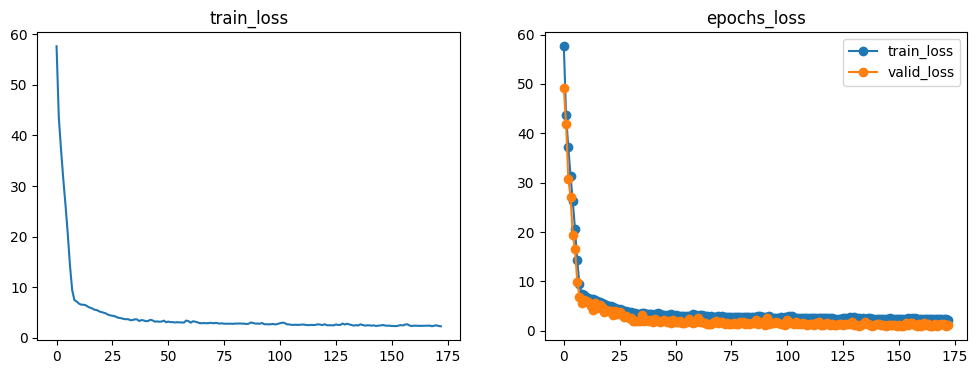

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_epochs_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss, '-o', label="train_loss")
plt.plot(valid_epochs_loss, '-o', label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()

# Tester

In [10]:
def tester(final=True):
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)

    print("Selecting features...")
    x_train, _, x_test, _, _ = select_feat(train_data, valid_data, test_data, select_all=False)

    test_dataset = COVID19Dataset(x_test)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    if final:
        model.load_state_dict(torch.load(model_final_path))
        print("***********- ***********- Using Final Model -*************")
    else:
        model.load_state_dict(torch.load(model_best_path))
        print("***********- ***********- Using Best Model -*************")

    print("***********- ***********- Test begin -*************")
    preds = []
    model.eval()
    # =========================test=======================
    for idx, (X) in enumerate(tqdm(test_dataloader)):
        if (len(args.gpus) > 0):
            X = X.cuda()
        with torch.no_grad():
            outputs = model(X)
            preds.append(outputs.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()

    print("***********- ***********- Save predictions -*************")
    save_file = args.submit_file
    with open(save_file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

    print("***********- ***********- Test finished -*************")

# Testing

In [11]:
tester(final=True)

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
Selecting features...
***********- ***********- Loading model -*************
***********- ***********- Using Single GPU -*************
***********- ***********- Using Final Model -*************
***********- ***********- Test begin -*************


100%|██████████| 5/5 [00:00<00:00,  9.35it/s]

***********- ***********- Save predictions -*************
***********- ***********- Test finished -*************
